In [3]:
import os

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.applications import Xception
from keras import layers
from keras.applications.xception import preprocess_input

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from tensorflow import keras as tk

In [5]:
_image_dir = '../datasets/celeba/img_align_celeba_png/'
_img_width = 178
_img_height = 218
_batch_size = 20
_num_epochs = 10

In [3]:
img_df = pd.read_csv('../datasets/celeba/attributes/attr_celeba.csv').replace({-1:0})[['filename', 'Eyeglasses', 'Smiling', 'Wearing_Lipstick', 'No_Beard', 'Young']]
partition_df = pd.read_csv('../datasets/celeba/attributes/list_eval_partition.csv')
img_df = img_df.merge(partition_df, on='filename')
img_df.loc[:, 'filename'] = img_df.loc[:, 'filename'].apply(lambda x: os.path.join(_image_dir, x))
img_df.head()

,filename,Eyeglasses,Smiling,Wearing_Lipstick,No_Beard,Young,partition
0,../datasets/celeba/img_align_celeba_png/000001...,0,1,1,1,1,0
1,../datasets/celeba/img_align_celeba_png/000002...,0,1,0,1,1,0
2,../datasets/celeba/img_align_celeba_png/000003...,0,0,0,1,1,0
3,../datasets/celeba/img_align_celeba_png/000004...,0,0,1,1,1,0
4,../datasets/celeba/img_align_celeba_png/000005...,0,0,1,1,1,0


In [4]:
train_df = img_df.loc[img_df.loc[:, 'partition'] == 0, ['filename', 'Eyeglasses', 'Smiling', 'Wearing_Lipstick', 'No_Beard', 'Young']]
valid_df = img_df.loc[img_df.loc[:, 'partition'] == 1, ['filename', 'Eyeglasses', 'Smiling', 'Wearing_Lipstick', 'No_Beard', 'Young']]
test_df = img_df.loc[img_df.loc[:, 'partition'] == 2, ['filename', 'Eyeglasses', 'Smiling', 'Wearing_Lipstick', 'No_Beard', 'Young']]

In [5]:
train_datagen =  ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2<<<<,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     brightness_range=[0.4,1.5],
    preprocessing_function=preprocess_input,
    rescale=1./255,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    batch_size=_batch_size,
    x_col='filename', 
    y_col='Eyeglasses',
    class_mode='raw',
    target_size=(_img_width, _img_height),
    validate_filenames=False)

Found 162770 non-validated image filenames.


In [30]:
valid_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    batch_size=_batch_size,
    x_col='filename', 
    y_col='Eyeglasses',
    class_mode='raw',
    target_size=(_img_width, _img_height),
    validate_filenames=False)

Found 19867 non-validated image filenames.


In [ ]:
base_model = Xception(
             input_shape=(_img_width, _img_height, 3), 
             include_top=False, 
             weights="imagenet"
        )

for layer in base_model.layers:
    layer.trainable = False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [57]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(8, activation="relu")(x)
x = layers.Dropout(0.7)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

In [45]:
model = keras.Model(inputs=base_model.input, outputs=outputs)
model.compile(
              optimizer=keras.optimizers.Adam(lr=0.01),
              loss='binary_crossentropy',
              metrics=[keras.metrics.AUC(name="auc")]
        )

In [46]:
checkpointer = ModelCheckpoint(filepath='weights.Eyeglasses_xception2.h5', verbose=1, save_best_only=True)
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    steps_per_epoch=len(train_df)//_batch_size,
                    validation_steps=len(valid_df) // _batch_size,
                    epochs=10,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/10
1271/1271 [==============================] - 67s 53ms/step - loss: 0.2448 - auc: 0.6966 - val_loss: 0.2113 - val_auc: 0.4270

Epoch 00001: val_loss improved from inf to 0.21128, saving model to weights.Eyeglasses_xception2.h5
Epoch 2/10
1271/1271 [==============================] - 65s 51ms/step - loss: 0.2114 - auc: 0.7312 - val_loss: 0.3329 - val_auc: 0.3616

Epoch 00002: val_loss did not improve from 0.21128
Epoch 3/10
1271/1271 [==============================] - 66s 52ms/step - loss: 0.2092 - auc: 0.7344 - val_loss: 0.0604 - val_auc: 0.4187

Epoch 00003: val_loss improved from 0.21128 to 0.06045, saving model to weights.Eyeglasses_xception2.h5
Epoch 4/10
1271/1271 [==============================] - 65s 51ms/step - loss: 0.2149 - auc: 0.7220 - val_loss: 0.0822 - val_auc: 0.4149

Epoch 00004: val_loss did not improve from 0.06045
Epoch 5/10
1271/1271 [==============================] - 65s 51ms/step - loss: 0.2067 - auc: 0.7126 - val_loss: 0.1991 - val_auc: 0.4022

Epoch 000

In [12]:
#model.load_weights('weights.Eyeglasses_xception2.h5')

In [47]:
test_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    batch_size=1,
    x_col='filename', 
    y_col='Eyeglasses',
    class_mode='raw',
    target_size=(_img_width, _img_height),
    validate_filenames=False,
    shuffle=False)

Found 19962 non-validated image filenames.


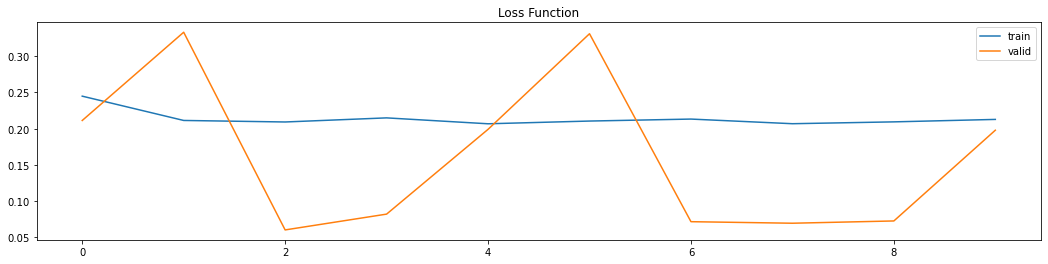

In [64]:
plt.figure(figsize=(18, 4))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

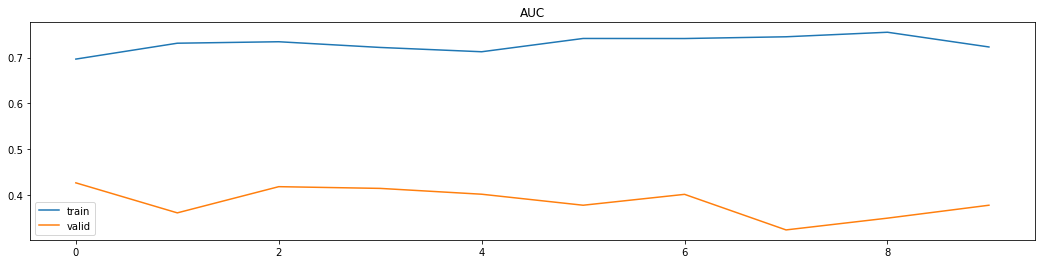

In [65]:
plt.figure(figsize=(18, 4))
plt.plot(history.history['auc'], label = 'train')
plt.plot(history.history['val_auc'], label = 'valid')
plt.legend()
plt.title('AUC')
plt.show()

In [51]:
model_predictions = model.predict(test_generator)

In [52]:
preds = np.array(model_predictions > 0.5).astype(int)

In [53]:
test_accuracy = 100 * accuracy_score(preds, test_df.loc[:, ['Eyeglasses']].values)
test_accuracy

93.5427311892596

In [54]:
f1 = f1_score(test_df.loc[:,  ['Eyeglasses']].values, preds)
f1

0.0

In [19]:
i = 0
for pred in preds:
    if pred == 1:
        i+=1

i

0

In [61]:
fpr, tpr, thresholds = roc_curve(test_df.loc[:,  ['Eyeglasses']].values, preds)
auc(fpr, tpr)

0.5